## Определение стоимости недвижимости из набора данных Ames Housing

Чтобы запускать и редактировать код, сохраните копию этого ноутбука себе (File->Save a copy in Drive...). Свою копию вы сможете изменять и запускать.

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
%matplotlib inline 

## Настраиваем Kaggle API

Загружаем токен для аутентификации

In [0]:
file = files.upload()

Saving kaggle.json to kaggle (1).json


Копируем токен в каталог .kaggle

In [0]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle

Загружаем данные с сайта Kaggle

In [0]:
!kaggle competitions download -c house-prices-advanced-regression-techniques

403 - Forbidden


## Просматриваем данные

In [0]:
!head train.csv

head: cannot open 'train.csv' for reading: No such file or directory


In [0]:
!cat data_description.txt

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

In [0]:
!head test.csv

Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1461,20,RH,80,11622,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0,TA,TA,CBlock,TA,TA,No

In [0]:
!head sample_submission.csv

Id,SalePrice
1461,169277.0524984
1462,187758.393988768
1463,183583.683569555
1464,179317.47751083
1465,150730.079976501
1466,177150.989247307
1467,172070.659229164
1468,175110.956519547
1469,162011.698831665


## Загружаем данные

In [0]:
train = pd.read_csv('train.csv')

In [0]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

Выделяем метки (целевую переменную)

In [0]:
y_train = train['SalePrice']

## Описательная статистика (exploratory data analysis)

Исследуем целевую переменную

In [0]:
y_train.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

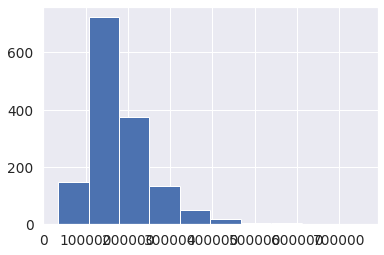

In [0]:
plt.hist(y_train)
plt.show()

Влияние признаков на целевую переменную

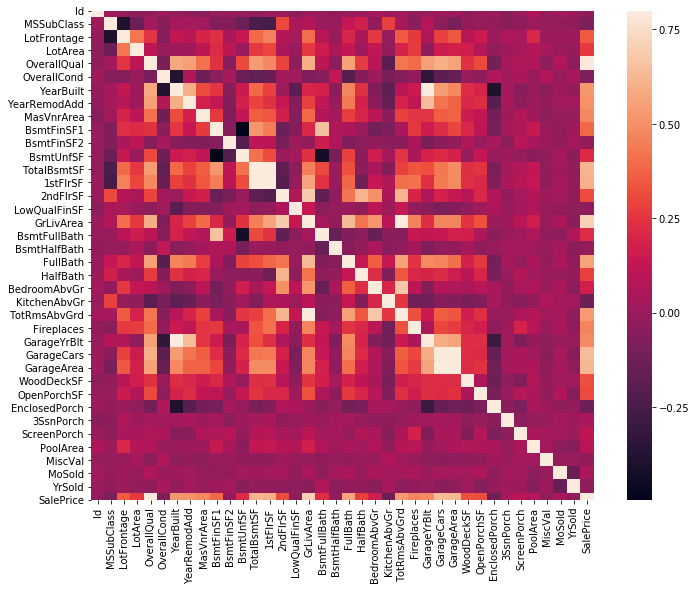

In [0]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

ТОП10 признаков

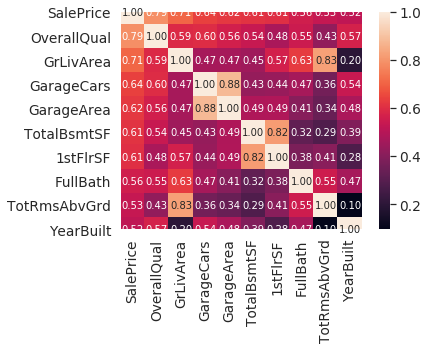

In [0]:
k = 10 
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Стоимость жилья в зависимости от жилой площади

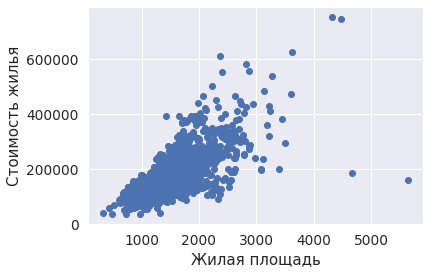

In [0]:
plt.scatter(train['GrLivArea'], y_train )
plt.xlabel('Жилая площадь')
plt.ylabel('Стоимость жилья')
plt.show()

Стоимость жилья в зависимости от площади подвала

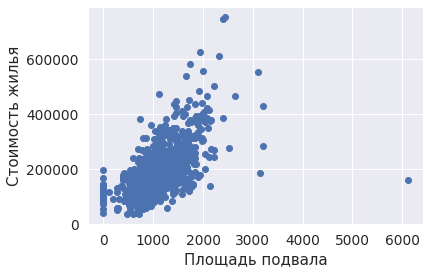

In [0]:
plt.scatter(train['TotalBsmtSF'], y_train )
plt.xlabel('Площадь подвала')
plt.ylabel('Стоимость жилья')
plt.show()

## Очистка данных

In [0]:
def clear_data(df):
    # Источник - https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset  

    # Заполняем отсутсвующие значения
    # Alley : data description says NA means "no alley access"
    df["Alley"] = df["Alley"].fillna("None")
    # BedroomAbvGr : NA most likely means 0
    df.loc[:, "BedroomAbvGr"] = df.loc[:, "BedroomAbvGr"].fillna(0)
    # BsmtQual etc : data description says NA for basement features is "no basement"
    df.loc[:, "BsmtQual"] = df.loc[:, "BsmtQual"].fillna("No")
    df.loc[:, "BsmtCond"] = df.loc[:, "BsmtCond"].fillna("No")
    df.loc[:, "BsmtExposure"] = df.loc[:, "BsmtExposure"].fillna("No")
    df.loc[:, "BsmtFinType1"] = df.loc[:, "BsmtFinType1"].fillna("No")
    df.loc[:, "BsmtFinType2"] = df.loc[:, "BsmtFinType2"].fillna("No")
    df.loc[:, "BsmtFullBath"] = df.loc[:, "BsmtFullBath"].fillna(0)
    df.loc[:, "BsmtHalfBath"] = df.loc[:, "BsmtHalfBath"].fillna(0)
    df.loc[:, "BsmtUnfSF"] = df.loc[:, "BsmtUnfSF"].fillna(0)
    # CentralAir : NA most likely means No
    df.loc[:, "CentralAir"] = df.loc[:, "CentralAir"].fillna("N")
    # Condition : NA most likely means Normal
    df.loc[:, "Condition1"] = df.loc[:, "Condition1"].fillna("Norm")
    df.loc[:, "Condition2"] = df.loc[:, "Condition2"].fillna("Norm")
    # EnclosedPorch : NA most likely means no enclosed porch
    df.loc[:, "EnclosedPorch"] = df.loc[:, "EnclosedPorch"].fillna(0)
    # External stuff : NA most likely means average
    df.loc[:, "ExterCond"] = df.loc[:, "ExterCond"].fillna("TA")
    df.loc[:, "ExterQual"] = df.loc[:, "ExterQual"].fillna("TA")
    # Fence : data description says NA means "no fence"
    df.loc[:, "Fence"] = df.loc[:, "Fence"].fillna("No")
    # FireplaceQu : data description says NA means "no fireplace"
    df.loc[:, "FireplaceQu"] = df.loc[:, "FireplaceQu"].fillna("No")
    df.loc[:, "Fireplaces"] = df.loc[:, "Fireplaces"].fillna(0)
    # Functional : data description says NA means typical
    df.loc[:, "Functional"] = df.loc[:, "Functional"].fillna("Typ")
    # GarageType etc : data description says NA for garage features is "no garage"
    df.loc[:, "GarageType"] = df.loc[:, "GarageType"].fillna("No")
    df.loc[:, "GarageFinish"] = df.loc[:, "GarageFinish"].fillna("No")
    df.loc[:, "GarageQual"] = df.loc[:, "GarageQual"].fillna("No")
    df.loc[:, "GarageCond"] = df.loc[:, "GarageCond"].fillna("No")
    df.loc[:, "GarageArea"] = df.loc[:, "GarageArea"].fillna(0)
    df.loc[:, "GarageCars"] = df.loc[:, "GarageCars"].fillna(0)
    # HalfBath : NA most likely means no half baths above grade
    df.loc[:, "HalfBath"] = df.loc[:, "HalfBath"].fillna(0)
    # HeatingQC : NA most likely means typical
    df.loc[:, "HeatingQC"] = df.loc[:, "HeatingQC"].fillna("TA")
    # KitchenAbvGr : NA most likely means 0
    df.loc[:, "KitchenAbvGr"] = df.loc[:, "KitchenAbvGr"].fillna(0)
    # KitchenQual : NA most likely means typical
    df.loc[:, "KitchenQual"] = df.loc[:, "KitchenQual"].fillna("TA")
    # LotFrontage : NA most likely means no lot frontage
    df.loc[:, "LotFrontage"] = df.loc[:, "LotFrontage"].fillna(0)
    # LotShape : NA most likely means regular
    df.loc[:, "LotShape"] = df.loc[:, "LotShape"].fillna("Reg")
    # MasVnrType : NA most likely means no veneer
    df.loc[:, "MasVnrType"] = df.loc[:, "MasVnrType"].fillna("None")
    df.loc[:, "MasVnrArea"] = df.loc[:, "MasVnrArea"].fillna(0)
    # MiscFeature : data description says NA means "no misc feature"
    df.loc[:, "MiscFeature"] = df.loc[:, "MiscFeature"].fillna("No")
    df.loc[:, "MiscVal"] = df.loc[:, "MiscVal"].fillna(0)
    # OpenPorchSF : NA most likely means no open porch
    df.loc[:, "OpenPorchSF"] = df.loc[:, "OpenPorchSF"].fillna(0)
    # PavedDrive : NA most likely means not paved
    df.loc[:, "PavedDrive"] = df.loc[:, "PavedDrive"].fillna("N")
    # PoolQC : data description says NA means "no pool"
    df.loc[:, "PoolQC"] = df.loc[:, "PoolQC"].fillna("No")
    df.loc[:, "PoolArea"] = df.loc[:, "PoolArea"].fillna(0)
    # SaleCondition : NA most likely means normal sale
    df.loc[:, "SaleCondition"] = df.loc[:, "SaleCondition"].fillna("Normal")
    # ScreenPorch : NA most likely means no screen porch
    df.loc[:, "ScreenPorch"] = df.loc[:, "ScreenPorch"].fillna(0)
    # TotRmsAbvGrd : NA most likely means 0
    df.loc[:, "TotRmsAbvGrd"] = df.loc[:, "TotRmsAbvGrd"].fillna(0)
    # Utilities : NA most likely means all public utilities
    df.loc[:, "Utilities"] = df.loc[:, "Utilities"].fillna("AllPub")
    # WoodDeckSF : NA most likely means no wood deck
    df.loc[:, "WoodDeckSF"] = df.loc[:, "WoodDeckSF"].fillna(0)
    
    # Представляем некоторые категориальные значения в виде числовых
    # если есть информация о порядке
    df = df.replace({"Alley" : {"None" : 0, "Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                     )    
    
    # Некоторые числовые переменные на самом деле категориальные
    df = df.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })
    
    return df

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

In [0]:
train = clear_data(train)

In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null object
MSZoning         1460 non-null object
LotFrontage      1460 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null int64
Alley            1460 non-null int64
LotShape         1460 non-null int64
LandContour      1460 non-null object
Utilities        1460 non-null int64
LotConfig        1460 non-null object
LandSlope        1460 non-null int64
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-nul

## Разделяем числовые и категориальные признаки

In [0]:
categorical_features = train.select_dtypes(include = ["object"]).columns
numerical_features = train.select_dtypes(exclude = ["object"]).columns

In [0]:
categorical_features

Index(['MSSubClass', 'MSZoning', 'LandContour', 'LotConfig', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
       'BsmtCond', 'Heating', 'CentralAir', 'Electrical', 'GarageType',
       'GarageFinish', 'Fence', 'MiscFeature', 'MoSold', 'SaleType',
       'SaleCondition'],
      dtype='object')

In [0]:
numerical_features

Index(['Id', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape',
       'Utilities', 'LandSlope', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'PoolQC', 'MiscVal', 'YrSold', 'SalePrice'],
      dtype='object')

Убираем из списка числовых переменных 'Id' и 'SalePrice'

In [0]:
numerical_features = numerical_features.drop("Id")
numerical_features = numerical_features.drop("SalePrice")

In [0]:
numerical_features

Index(['LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'Utilities',
       'LandSlope', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageYrBlt', 'GarageCars',
       'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'PoolQC', 'MiscVal', 'YrSold'],
      dtype='object')

Разделяем данные на числовые и категориальные

In [0]:
train_numerical = train[numerical_features]
train_categorical = train[categorical_features]

In [0]:
train_numerical[:5]

,LotFrontage,LotArea,Street,Alley,LotShape,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,YrSold
0,65.0,8450,2,0,4,4,3,7,5,2003,2003,196.0,4,3,4,0,6,706,1,0,150,856,5,856,854,0,1710,1,0,2,1,3,1,4,8,8,0,0,2003.0,2,548,3,3,2,0,61,0,0,0,0,0,0,2008
1,80.0,9600,2,0,4,4,3,6,8,1976,1976,0.0,3,3,4,3,5,978,1,0,284,1262,5,1262,0,0,1262,0,1,2,0,3,1,3,6,8,1,3,1976.0,2,460,3,3,2,298,0,0,0,0,0,0,0,2007
2,68.0,11250,2,0,3,4,3,7,5,2001,2002,162.0,4,3,4,1,6,486,1,0,434,920,5,920,866,0,1786,1,0,2,1,3,1,4,6,8,1,3,2001.0,2,608,3,3,2,0,42,0,0,0,0,0,0,2008
3,60.0,9550,2,0,3,4,3,7,5,1915,1970,0.0,3,3,3,0,5,216,1,0,540,756,4,961,756,0,1717,1,0,1,0,3,1,4,7,8,1,4,1998.0,3,642,3,3,2,0,35,272,0,0,0,0,0,2006
4,84.0,14260,2,0,3,4,3,8,5,2000,2000,350.0,4,3,4,2,6,655,1,0,490,1145,5,1145,1053,0,2198,1,0,2,1,4,1,4,9,8,1,3,2000.0,3,836,3,3,2,192,84,0,0,0,0,0,0,2008


In [0]:
train_categorical[:5]

,MSSubClass,MSZoning,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,BsmtCond,Heating,CentralAir,Electrical,GarageType,GarageFinish,Fence,MiscFeature,MoSold,SaleType,SaleCondition
0,SC60,RL,Lvl,Inside,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,3,GasA,Y,SBrkr,Attchd,RFn,No,No,Feb,WD,Normal
1,SC20,RL,Lvl,FR2,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,CBlock,3,GasA,Y,SBrkr,Attchd,RFn,No,No,May,WD,Normal
2,SC60,RL,Lvl,Inside,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,3,GasA,Y,SBrkr,Attchd,RFn,No,No,Sep,WD,Normal
3,SC70,RL,Lvl,Corner,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,BrkTil,4,GasA,Y,SBrkr,Detchd,Unf,No,No,Feb,WD,Abnorml
4,SC60,RL,Lvl,FR2,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,3,GasA,Y,SBrkr,Attchd,RFn,No,No,Dec,WD,Normal


## Предварительная обработка числовых признаков

Количество пустых значений числовых признаков

In [0]:
train_numerical.isnull().values.sum()

81

Заполняем пустые значения средними значениями

In [0]:
train_numerical = train_numerical.fillna(train_numerical.median())

Проверяем количество пустых значений числовых признаков

In [0]:
train_numerical.isnull().values.sum()

0

## Нормализуем числовые признаки

In [0]:
# Среднее значение
mean = train_numerical.mean(axis=0)
# Стандартное отклонение
std = train_numerical.std(axis=0)
train_numerical -= mean
train_numerical /= std

## Предварительная обработка категориальных значений

In [0]:
train_categorical['BldgType'].describe()

count     1460
unique       5
top       1Fam
freq      1220
Name: BldgType, dtype: object

BldgType: Type of dwelling
		
       1Fam	Single-family Detached	
       2FmCon	Two-family Conversion; originally built as one-family dwelling
       Duplx	Duplex
       TwnhsE	Townhouse End Unit
       TwnhsI	Townhouse Inside Unit

In [0]:
set(train_categorical['BldgType'])

{'1Fam', '2fmCon', 'Duplex', 'Twnhs', 'TwnhsE'}

In [0]:
blgd_type_dummy = pd.get_dummies(train_categorical['BldgType'])

In [0]:
blgd_type_dummy[:20]

,1Fam,2fmCon,Duplex,Twnhs,TwnhsE
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
5,1,0,0,0,0
6,1,0,0,0,0
7,1,0,0,0,0
8,1,0,0,0,0
9,0,1,0,0,0


In [0]:
train_categorical = pd.get_dummies(train_categorical)

In [0]:
train_categorical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 205 entries, MSSubClass_SC120 to SaleCondition_Partial
dtypes: uint8(205)
memory usage: 292.4 KB


In [0]:
train_categorical[:5]

,MSSubClass_SC120,MSSubClass_SC160,MSSubClass_SC180,MSSubClass_SC190,MSSubClass_SC20,MSSubClass_SC30,MSSubClass_SC40,MSSubClass_SC45,MSSubClass_SC50,MSSubClass_SC60,MSSubClass_SC70,MSSubClass_SC75,MSSubClass_SC80,MSSubClass_SC85,MSSubClass_SC90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,...,GarageFinish_No,GarageFinish_RFn,GarageFinish_Unf,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_No,MiscFeature_Gar2,MiscFeature_No,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MoSold_Apr,MoSold_Aug,MoSold_Dec,MoSold_Feb,MoSold_Jan,MoSold_Jul,MoSold_Jun,MoSold_Mar,MoSold_May,MoSold_Nov,MoSold_Oct,MoSold_Sep,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


Проверяем количество пустых значений категориальных признаков

In [0]:
train_categorical.isnull().values.sum()

0

## Готовим общий набор данных

In [0]:
x_train = pd.concat([train_numerical, train_categorical], axis = 1)

In [0]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 258 entries, LotFrontage to SaleCondition_Partial
dtypes: float64(53), uint8(205)
memory usage: 896.9 KB


In [0]:
x_train[:5]

,LotFrontage,LotArea,Street,Alley,LotShape,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageCars,...,GarageFinish_No,GarageFinish_RFn,GarageFinish_Unf,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_No,MiscFeature_Gar2,MiscFeature_No,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MoSold_Apr,MoSold_Aug,MoSold_Dec,MoSold_Feb,MoSold_Jan,MoSold_Jul,MoSold_Jun,MoSold_Mar,MoSold_May,MoSold_Nov,MoSold_Oct,MoSold_Sep,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.212804,-0.207071,0.064216,-0.242942,0.701051,0.026171,0.225639,0.651256,-0.517023,1.050634,0.878367,0.513928,1.051942,-0.238031,0.582968,-0.63146,1.164313,0.575228,-0.277094,-0.288554,-0.944267,-0.459145,0.890874,-0.793162,1.161454,-0.120201,0.370207,1.107431,-0.240978,0.789470,1.227165,0.163723,-0.211381,0.735742,0.911897,0.236962,-0.950901,-1.007988,1.017250,0.311618,...,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,0.645526,-0.091855,0.064216,-0.242942,0.701051,0.026171,0.225639,-0.071812,2.178881,0.156680,-0.429430,-0.570555,-0.689368,-0.238031,0.582968,2.25559,0.689879,1.171591,-0.277094,-0.288554,-0.641008,0.466305,0.890874,0.257052,-0.794891,-0.120201,-0.482347,-0.819684,3.947457,0.789470,-0.761360,0.163723,-0.211381,-0.770827,-0.318574,0.236962,0.600289,0.648668,-0.107890,0.311618,...,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,0.299349,0.073455,0.064216,-0.242942,-1.016288,0.026171,0.225639,0.651256,-0.517023,0.984415,0.829930,0.325803,1.051942,-0.238031,0.582968,0.33089,1.164313,0.092875,-0.277094,-0.288554,-0.301540,-0.313261,0.890874,-0.627611,1.188943,-0.120201,0.514836,1.107431,-0.240978,0.789470,1.227165,0.163723,-0.211381,0.735742,-0.318574,0.236962,0.600289,0.648668,0.933906,0.311618,...,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,0.068564,-0.096864,0.064216,-0.242942,-1.016288,0.026171,0.225639,0.651256,-0.517023,-1.862993,-0.720051,-0.570555,-0.689368,-0.238031,-0.557961,-0.63146,0.689879,-0.499103,-0.277094,-0.288554,-0.061648,-0.687089,-0.151334,-0.521555,0.936955,-0.120201,0.383528,1.107431,-0.240978,-1.025689,-0.761360,0.163723,-0.211381,0.735742,0.296662,0.236962,0.600289,1.200886,0.808890,1.649742,...,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
4,0.760919,0.375020,0.064216,-0.242942,-1.016288,0.026171,0.225639,1.374324,-0.517023,0.951306,0.733056,1.366021,1.051942,-0.238031,0.582968,1.29324,1.164313,0.463410,-0.277094,-0.288554,-0.174805,0.199611,0.890874,-0.045596,1.617323,-0.120201,1.298881,1.107431,-0.240978,0.789470,1.227165,1.389547,-0.211381,0.735742,1.527133,0.236962,0.600289,0.648668,0.892234,1.649742,...,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


## Создаем нейронную сеть

In [0]:
model = Sequential()
model.add(Dense(200, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(1, activation='relu'))

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               51800     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 26        
Total params: 78,251
Trainable params: 78,251
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='adadelta', loss='mse', metrics=['mae'])

## Обучаем нейронную сеть

In [0]:
history = model.fit(x_train, 
                    y_train, 
                    epochs=100, 
                    validation_split=0.1, 
                    verbose=2)

Train on 1314 samples, validate on 146 samples
Epoch 1/100
1314/1314 - 0s - loss: 39366228868.8706 - mean_absolute_error: 181505.2812 - val_loss: 36096564434.4110 - val_mean_absolute_error: 175664.4375
Epoch 2/100
1314/1314 - 0s - loss: 39366228039.6956 - mean_absolute_error: 181505.2500 - val_loss: 36096562105.8630 - val_mean_absolute_error: 175664.4375
Epoch 3/100
1314/1314 - 0s - loss: 39366227721.7412 - mean_absolute_error: 181505.2812 - val_loss: 36096561264.2192 - val_mean_absolute_error: 175664.4375
Epoch 4/100
1314/1314 - 0s - loss: 39366226724.2374 - mean_absolute_error: 181505.2656 - val_loss: 36096561432.5479 - val_mean_absolute_error: 175664.4219
Epoch 5/100
1314/1314 - 0s - loss: 39366225343.3181 - mean_absolute_error: 181505.2500 - val_loss: 36096560590.9041 - val_mean_absolute_error: 175664.4375
Epoch 6/100
1314/1314 - 0s - loss: 39366223850.1796 - mean_absolute_error: 181505.2344 - val_loss: 36096557729.3151 - val_mean_absolute_error: 175664.4062
Epoch 7/100
1314/1314 -

## Готовим данные для предсказания

In [0]:
test = pd.read_csv('test.csv')

In [0]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
Id               1459 non-null int64
MSSubClass       1459 non-null int64
MSZoning         1455 non-null object
LotFrontage      1232 non-null float64
LotArea          1459 non-null int64
Street           1459 non-null object
Alley            107 non-null object
LotShape         1459 non-null object
LandContour      1459 non-null object
Utilities        1457 non-null object
LotConfig        1459 non-null object
LandSlope        1459 non-null object
Neighborhood     1459 non-null object
Condition1       1459 non-null object
Condition2       1459 non-null object
BldgType         1459 non-null object
HouseStyle       1459 non-null object
OverallQual      1459 non-null int64
OverallCond      1459 non-null int64
YearBuilt        1459 non-null int64
YearRemodAdd     1459 non-null int64
RoofStyle        1459 non-null object
RoofMatl         1459 non-null object
Exterior1st      1458 non-

In [0]:
test = clear_data(test)

In [0]:
test_numerical = test[numerical_features]
test_categorical = test[categorical_features]

In [0]:
test_numerical = test_numerical.fillna(test_numerical.median())

In [0]:
test_numerical -= mean
test_numerical /= std

In [0]:
test_categorical = pd.get_dummies(test_categorical)

In [0]:
additional_columns = []
for column in train_categorical.columns:
    if column not in test_categorical.columns:
        additional_columns.append(column)
        test_categorical[column] = 0

In [0]:
additional_columns

['Condition2_RRAe',
 'Condition2_RRAn',
 'Condition2_RRNn',
 'HouseStyle_2.5Fin',
 'RoofMatl_ClyTile',
 'RoofMatl_Membran',
 'RoofMatl_Metal',
 'RoofMatl_Roll',
 'Exterior1st_ImStucc',
 'Exterior1st_Stone',
 'Exterior2nd_Other',
 'Heating_Floor',
 'Heating_OthW',
 'Electrical_Mix',
 'MiscFeature_TenC']

In [0]:
x_test = pd.concat([test_numerical[train_numerical.columns], test_categorical[train_categorical.columns]], axis = 1)

In [0]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Columns: 258 entries, LotFrontage to SaleCondition_Partial
dtypes: float64(53), int64(15), uint8(190)
memory usage: 1.0 MB


## Запускаем предсказание

In [0]:
predictions = model.predict(x_test)

In [0]:
predictions[:20]

array([[ 8.5432005],
       [13.7037115],
       [ 9.036744 ],
       [ 9.227079 ],
       [ 9.949407 ],
       [ 9.077138 ],
       [ 8.3000765],
       [ 9.427537 ],
       [ 8.306016 ],
       [ 7.708619 ],
       [ 7.904434 ],
       [ 9.048619 ],
       [ 9.182724 ],
       [ 8.071173 ],
       [ 8.664004 ],
       [ 9.596239 ],
       [ 9.520439 ],
       [ 9.184066 ],
       [ 9.817115 ],
       [ 8.27886  ]], dtype=float32)

## Готовим решение для Kaggle

In [0]:
out = np.column_stack((test['Id'], predictions))

In [0]:
out[:10]

array([[1461.        ,    8.54320049],
       [1462.        ,   13.70371151],
       [1463.        ,    9.03674412],
       [1464.        ,    9.22707939],
       [1465.        ,    9.94940662],
       [1466.        ,    9.07713795],
       [1467.        ,    8.30007648],
       [1468.        ,    9.42753696],
       [1469.        ,    8.30601597],
       [1470.        ,    7.70861912]])

In [0]:
np.savetxt('submission.csv', out, header="Id,SalePrice", 
            comments="", fmt="%d,%f")

In [0]:
!head submission.csv

Id,SalePrice
1461,8.543200
1462,13.703712
1463,9.036744
1464,9.227079
1465,9.949407
1466,9.077138
1467,8.300076
1468,9.427537
1469,8.306016


## Отправляем решение на Kaggle

In [0]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -m "Baseline submition from Colab" -f submission.csv

100% 20.0k/20.0k [00:04<00:00, 4.97kB/s]
Successfully submitted to House Prices: Advanced Regression Techniques

## Домашнее задание

Примите условия участия в соревновании - https://www.kaggle.com/c/house-prices-advanced-regression-techniques

Улучшайте решение, чтобы занять более высокое место в соревновании. Для этого:

1. Изучите подготовку данных в опубликованных решениях:
    - https://www.kaggle.com/apapiu/regularized-linear-models
    - https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset
    - https://www.kaggle.com/hugosjoberg/house-prices-prediction-using-keras
    - https://www.kaggle.com/diegosiebra/neural-network-model-for-house-prices-keras

    Попробуйте применять подходы из этих решений.

2. Попробуйте применить другой тип модели.

4. Удалите выбросы из обучающего набора данных (дома с площадью более 4000).

5. Удалите из набора данных признаки с высокой корреляцией (связанные между собой). Смотрите примеры в ноутбуках из пункта 1.

6. Добавьте производных признаков в данные для обучения (смотрите примеры в ноутбуках из пункта 1).

